In [1]:
import gym
import ma_gym 
import numpy as np
import random
import pandas as pd
from ma_gym.envs.traffic_junction import TrafficJunction  
from collections import defaultdict
import nashpy as nash
from dqn import DQNAgent
import matplotlib.pyplot as plt
from ppo import PPOAgent


Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-yz90k3yq because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Seeds for reproducibility
seeds = [0, 1]

# Initialize dictionaries to store results


/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Generation 1/2
Solving for Nash Equilibrium in Generation 1/2
Computing Nash Equilibrium for 100 matches
Episode 1/2


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 2/2
Generation 2/2
Solving for Nash Equilibrium in Generation 2/2
Computing Nash Equilibrium for 100 matches
Episode 1/2
Episode 2/2
Running Computed Policies
Episode 0 done
Episode 1 done
Episode 2 done
Episode 3 done
Episode 4 done
Episode 5 done
Episode 6 done
Episode 7 done
Episode 8 done
Episode 9 done


/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Generation 1/2
Solving for Nash Equilibrium in Generation 1/2
Computing Nash Equilibrium for 100 matches
Episode 1/2


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 2/2
Generation 2/2
Solving for Nash Equilibrium in Generation 2/2
Computing Nash Equilibrium for 100 matches
Episode 1/2


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 2/2
Running Computed Policies
Episode 0 done
Episode 1 done
Episode 2 done
Episode 3 done
Episode 4 done
Episode 5 done
Episode 6 done
Episode 7 done
Episode 8 done
Episode 9 done


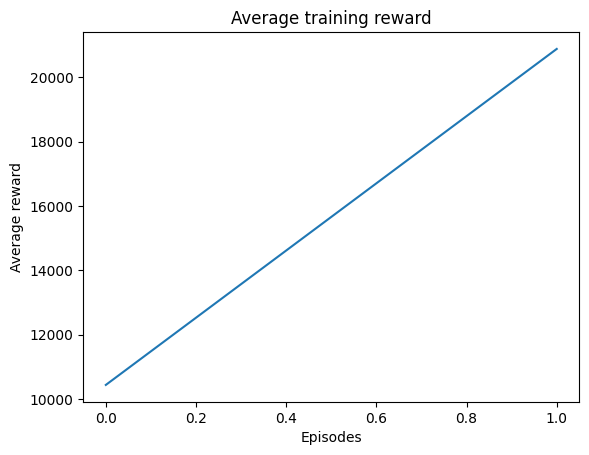

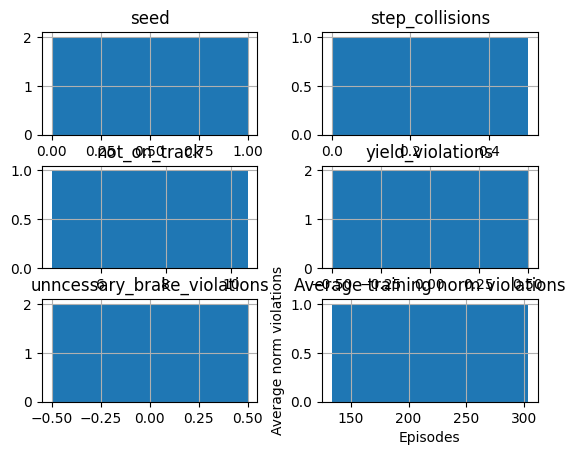

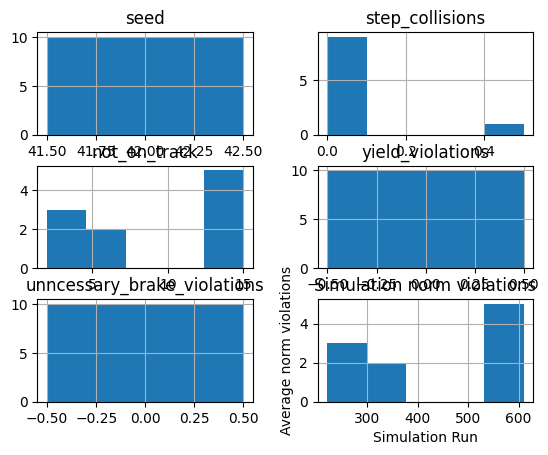

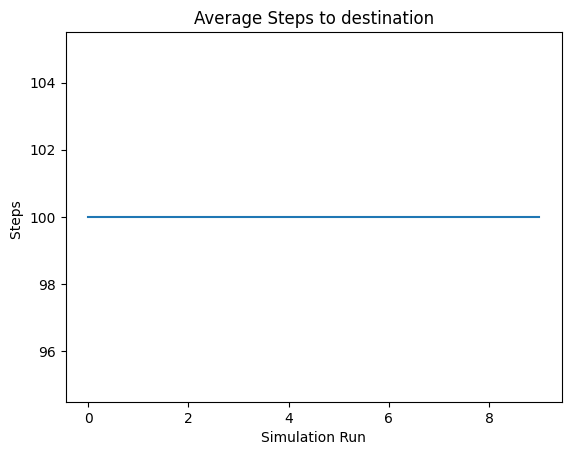

In [4]:
from main import simulation_10_agents, simulation_4_agents, simulation_10_to_4_agents
import copy


avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f = None, None, None, None
for seed in seeds:
    avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest= simulation_10_agents(seed, False) 
    if seed == seeds[0]:
        avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f = avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest
    else:
        avg_training_rewards_f = [sum(x) / 2 for x in zip(avg_training_rewards_f, avg_training_rewards)]
        avg_training_norm_violations_f = avg_training_norm_violations_f.add(avg_training_norm_violations).div(2)
        sim_violated_f = sim_violated_f.add(sim_violated).div(2)
        at_dest_f = [sum(x) / 2 for x in zip(at_dest_f, at_dest)]

#plot results
plt.plot(avg_training_rewards_f)
plt.title('Average training reward')
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()


#training violations
costs_from_violations = copy.deepcopy(avg_training_norm_violations_f['total_violations_cost'])
avg_training_norm_violations_f.drop(columns=['total_violations_cost'], inplace=True)
avg_training_norm_violations_f.hist(bins='auto', stacked=True)
plt.title('Average training norm violations')
plt.xlabel('Episodes')
plt.ylabel('Average norm violations')
plt.show()

#simulation violations
costs_from_violations = copy.deepcopy(sim_violated_f['total_violations_cost'])
sim_violated_f.drop(columns=['total_violations_cost'], inplace=True)
sim_violated_f.hist(bins='auto', stacked=True)
plt.title('Simulation norm violations')
plt.xlabel('Simulation Run')
plt.ylabel('Average norm violations')
plt.show()

#simulation at destination, avg timeto destination
plt.plot(at_dest_f)
plt.title('Average Steps to destination')
plt.xlabel('Simulation Run')
plt.ylabel('Steps ')
plt.show()






